In [1]:
import json
import numpy as np
import xobjects as xo
import xtrack as xt
import xpart as xp
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy import constants 
####################
# Choose a context #
####################
context = xo.ContextCpu()
# context = xo.ContextCpu(omp_num_threads='auto')
buf = context.new_buffer()

# Ion properties:
m_u = 931.49410242e6 # eV/c^2 -- atomic mass unit
A = 207.98 # Lead-208
Z = 82  # Number of protons in the ion (Lead)
Ne = 3 # Number of remaining electrons (Lithium-like)
m_e = 0.511e6 # eV/c^2 -- electron mass
m_p = 938.272088e6 # eV/c^2 -- proton mass
c = 299792458.0 # m/s

m_ion = A*m_u + Ne*m_e # eV/c^2
equiv_proton_momentum = 236e9 # eV/c = gamma_p*m_p*v
gamma_p = np.sqrt( 1 + (equiv_proton_momentum/m_p)**2 ) # equvalent gamma for protons in the ring

p0c = equiv_proton_momentum*(Z-Ne) # eV/c
gamma = np.sqrt( 1 + (p0c/m_ion)**2 ) # ion relativistic factor
beta = np.sqrt(1-1/(gamma*gamma)) # ion beta


In [2]:
#%%
##################
# Build TrackJob #
##################

fname_sequence ='/home/pkruyt/cernbox/xsuite-env/xtrack/test_data/sps_w_spacecharge/line_no_spacecharge_and_particle.json'

with open(fname_sequence, 'r') as fid:
     input_data = json.load(fid)
sequence = xt.Line.from_dict(input_data['line'])

n_part = int(1e6)

SPS_tracker = xt.Tracker(_context=context, _buffer=buf, line=sequence)

# Build a reference particle
particle_sample = xp.Particles(mass0=m_ion, q0=Z-Ne, p0c=p0c)

sigma_z = 22.5e-2
nemitt_x = 2e-6
nemitt_y = 2.5e-6


particles = xp.generate_matched_gaussian_bunch(
         num_particles=n_part,
         #total_intensity_particles=bunch_intensity,
         nemitt_x=nemitt_x, nemitt_y=nemitt_y, sigma_z=sigma_z,
         #R_matrix=r_matrix,
         particle_ref=particle_sample,
         tracker=SPS_tracker
         #,steps_r_matrix=steps_r_matrix
         )


sequence.particle_ref = particle_sample
twiss = sequence.twiss(symplectify=True)

twiss_dict=dict(twiss)

#%%
###################
# Linear Transfer #
###################

arc=xt.LinearTransferMatrix(Q_x=twiss['qx'], Q_y=twiss['qy'],
beta_x_0=twiss['betx'][0], beta_x_1=twiss['betx'][-1],
beta_y_0=twiss['bety'][0], beta_y_1=twiss['bety'][-1],
alpha_x_0=twiss['alfx'][0], alpha_x_1=twiss['alfx'][-1],
alpha_y_0=twiss['alfy'][0], alpha_y_1=twiss['alfy'][-1],
disp_x_0=twiss['dx'][0], disp_x_1=twiss['dx'][-1],
disp_y_0=twiss['dy'][0], disp_y_1=twiss['dy'][-1],
beta_s=twiss['betz0'],
Q_s=-twiss['qs'],
chroma_x=twiss['dqx'], chroma_y=twiss['dqy'])

SPS_lin = xt.Line()

SPS_lin.append_element(arc,'SPS_LinearTransferMatrix') 

Done loading line from dict.           
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
The argument tracker is deprecated. Please use line instead. <class 'DeprecationWarning'>
*** Maximum RMS bunch length 0.23592919520901076m.
... distance to target bunch length: -2.2500e-01
... distance to target bunch length: 4.4112e-03
... distance to target bunch length: 4.1449e-03
... distance to target bunch length: -3.3479e-03
... distance to target bunch length: 1.0467e-03
... distance to target bunch length: 2.0728e-04
... distance to target bunch length: -3.3833e-06
... distance to target bunch length: 4.9353e-08
... distance to target bunch length: -6.5924e-08
--> Bunch length: 0.2250000493531224
--> Emittance: 0.6606168164388687
Warning! scale_with_transverse_norm_emitt is deprecated. Use nemitt_x and nemitt_y instead.


In [3]:
##################
# Laser Cooler #
##################

sigma_dp = 2e-4 # relative ion momentum spread
#sigma_dp = std_delta # relative ion momentum spread


#laser-ion beam collision angle
theta_l = 2.6*np.pi/180 # rad
theta_l = 0
nx = 0; ny = -np.sin(theta_l); nz = -np.cos(theta_l)

# Ion excitation energy:
hw0 = 230.823 # eV
hc=constants.hbar*c/constants.e # eV*m (ħc)
lambda_0 = 2*np.pi*hc/hw0 # m -- ion excitation wavelength

lambda_l = lambda_0*gamma*(1 + beta*np.cos(theta_l)) # m -- laser wavelength

# Shift laser wavelength for fast longitudinal cooling:
lambda_l = lambda_l*(1+1*sigma_dp) # m

laser_frequency = c/lambda_l # Hz
sigma_w = 2*np.pi*laser_frequency*sigma_dp
#sigma_w = 2*np.pi*laser_frequency*sigma_dp/2 # for fast longitudinal cooling


sigma_t = 1/sigma_w # sec -- Fourier-limited laser pulse
print('Laser pulse duration sigma_t = %.2f ps' % (sigma_t/1e-12))

print('Laser wavelength = %.2f nm' % (lambda_l/1e-9))

laser_waist_radius = 1.3e-3
#laser_waist_radius = 1.3e-7

laser_x=0.0020000
laser_x=0.000000

gamma0=96

I=100000000000

laser_power=I/4/gamma0/gamma0

GF_IP = xt.CWLaser(_buffer=buf,
                      laser_x=laser_x,
                      laser_y=0,
                      laser_z=10e-3,
                      
                      laser_direction_nx = 0,
                      laser_direction_ny = 0,
                      laser_direction_nz = -1,
                      laser_energy         = 5e-3, # J
                      laser_duration_sigma = sigma_t, # sec
                      laser_wavelength = lambda_l, # m
                      laser_waist_radius = laser_waist_radius, # m
                      laser_power=laser_power,
                      ion_excitation_energy = hw0, # eV
                      ion_excited_lifetime  = 76.6e-12, # sec
                          
   )
                          
   
SPS_lin.append_element(GF_IP, 'GammaFactory_IP')

##################
# Tracking #
##################
x, px, delta, action_x = [], [], [], []
num_turns = int(1e0)
# loop over turns
for i in tqdm(range(num_turns)):
    
    x.append(particles.x)
    px.append(particles.px)
    delta.append(particles.delta)
    
    # track particle
    arc.track(particles)
    GF_IP.track(particles)

excited=particles.state==2

fraction_excitation = sum(excited)/len(excited)

Laser pulse duration sigma_t = 2.74 ps
Laser wavelength = 1034.07 nm


  0%|          | 0/1 [00:00<?, ?it/s]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...


58b8355a4e4842c8a4266e4da164d9ba.c: In function ‘CWLaser_track_local_particle’:
58b8355a4e4842c8a4266e4da164d9ba.c:3439:9: warning: multi-line comment [-Wcomment]
         // double OmegaRabi = \
         ^
58b8355a4e4842c8a4266e4da164d9ba.c:3431:16: warning: unused variable ‘r2’ [-Wunused-variable]
         double r2 = (\
                ^~
58b8355a4e4842c8a4266e4da164d9ba.c:3369:12: warning: unused variable ‘beta0’ [-Wunused-variable]
     double beta0  = sqrt(1.0 - 1.0/(gamma0*gamma0));
            ^~~~~
58b8355a4e4842c8a4266e4da164d9ba.c:3357:13: warning: unused variable ‘d_Delta_over_Gamma’ [-Wunused-variable]
     double  d_Delta_over_Gamma = Delta_over_Gamma_max/(N_Delta_over_Gamma_values-1.0);
             ^~~~~~~~~~~~~~~~~~
58b8355a4e4842c8a4266e4da164d9ba.c:3356:13: warning: unused variable ‘d_k1’ [-Wunused-variable]
     double  d_k1 = k1_max/(N_k1_values-1.0);
             ^~~~
58b8355a4e4842c8a4266e4da164d9ba.c:3339:12: warning: unused variable ‘w0’ [-Wunused-variable]
   

Done compiling ContextCpu kernels.


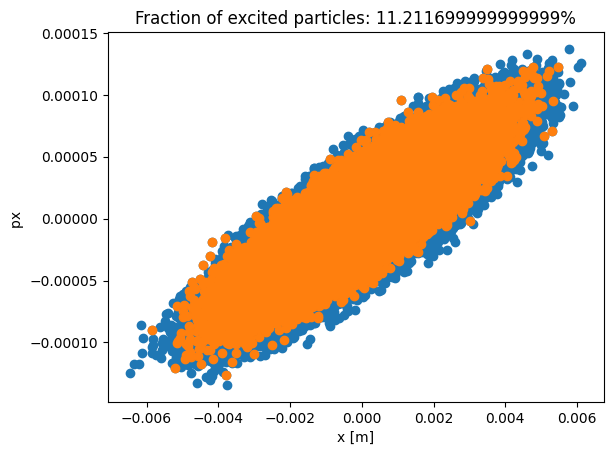

In [4]:
plt.figure()
plt.title(f'Fraction of excited particles: {fraction_excitation*100}%')

#plt.axvline(laser_x,color='red')
# plt.axvline(laser_x+laser_waist_radius,color='red')
# plt.axvline(laser_x-laser_waist_radius,color='red')

plt.scatter(particles.x,particles.px)
plt.scatter(particles.x[excited],particles.px[excited])
plt.xlabel('x [m]')
plt.ylabel('px ')
plt.show()

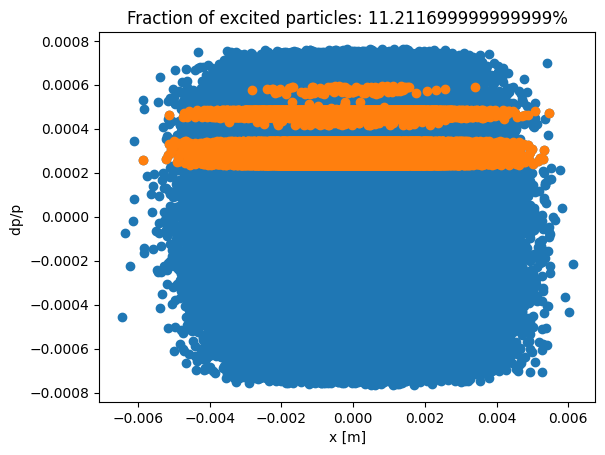

In [5]:
plt.figure()
plt.title(f'Fraction of excited particles: {fraction_excitation*100}%')

#plt.axvline(laser_x,color='red')
# plt.axvline(laser_x+laser_waist_radius,color='red')
# plt.axvline(laser_x-laser_waist_radius,color='red')

plt.scatter(particles.x,particles.delta)
plt.scatter(particles.x[excited],particles.delta[excited])
plt.xlabel('x [m]')
plt.ylabel('dp/p ')
plt.show()

In [6]:
# def excitation_plot(laser_energy_mJ=GF_IP.laser_energy/1e-3,
#                     laser_duration_sigma_ps=GF_IP.laser_duration_sigma/1e-12,
#                     laser_waist_radius_mm=GF_IP.laser_waist_radius/1e-3):
    
#     GF_IP.laser_energy = laser_energy_mJ*1e-3
#     GF_IP.laser_duration_sigma = laser_duration_sigma_ps*1e-12
#     GF_IP.laser_waist_radius = laser_waist_radius_mm*1e-3
    
#     particles = particles.copy()
#     tracker.track(particles, num_turns=1)
    
#     x  = particles.x*1000 # mm
#     y  = particles.y*1000 # mm
#     z  = particles.zeta*100 # cm
#     dp = particles.delta*100 # percent
#     excited = (particles.state == 2)
    
#     img = \
#         hv.Points((z,x), kdims=[dim_z,dim_x]) * \
#         hv.Points((z[excited],x[excited]), kdims=[dim_z,dim_x], group='Excited') * \
#         hv.Text(-8, 3.0, f'{100*len(z[excited])/len(z):.1f}% of ions are excited') + \
#     \
#         hv.Points((z,y), kdims=[dim_z,dim_y]) * \
#         hv.Points((z[excited],y[excited]), kdims=[dim_z,dim_y], group='Excited') + \
#     \
#         hv.Points((z,dp), kdims=[dim_z,dim_dp]) * \
#         hv.Points((z[excited],dp[excited]), kdims=[dim_z,dim_dp], group='Excited')

    
#     return img.cols(1).opts(tight=True)
